In [45]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util

###############################################################
# LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/home/trainner/Documents/GitHub/Photonics-training/Projects/MMI/Lumerical files')) #Current directory


###############################################################
# WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/MMI/Lumericalfiles/'))
spec_win.loader.exec_module(lumapi)

In [2]:
mmi = lumapi.MODE(filename='MMIProject.lms',hide=False) 

## Functions

In [3]:
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })

## Assembly parameters

In [110]:
# Body config------------------------------------
BdX_Span = 31.87e-6 # Body X Span
BdY_Span = 6e-6 # Body y Span


# Ports config-----------------------------------

OutMx = [1.6e-6,-1.6e-6] # Array of output ports y positions (put 0 on first element to ignore this line)
InMx = [0]               # Array of input ports y positions (put 0 on first element to ignore this line) 

# If the lines above has to be ignored, use these ones instead: 
InP = 1 # Number of Input ports
OutP = 2 # Number of Output ports
Asy = 0 # Force asymmetry on inputs ports auto-displacement (0 -> Symetry, 1 -> Asymmetry)
         
PYSpan_in = 12e-6 # Input Port Y Span 
PYSpan_out = 3e-6 # Output Port Y Span 


# Tappers config---------------------------------
SetToTappers = 1 # Set tappers as inputs/outputs
TLen = 4e-6 # Tapper Length
TWidth = 1e-6 # Tapper Width


# Mesh config------------------------------------
MeshEnableIn = 0 # enable input mesh insertion
MeshEnableOut = 1 # enable output mesh insertion
MeshType = 1 # 0 for Override, 1 for Multipler

MeshOver = [[0.05e-6,0.05e-6,0.05e-6] , [0.05e-6,0.05e-6,0.05e-6]] # Override mesh value dx,dy and dz ([[Input Mesh],[Output Mesh]])
MeshMultiplier = [[2,2,2] , [4,4,4]] # Mesh multipler value dx,dy and dz ([[Input Mesh],[Output Mesh]])


# EME config-------------------------------------
EME_MC = 100 # Number of EME Mesh Cells (Y and Z)
SideCells = 4 # Number of Cells on Input/Output groups

## Assembly

In [111]:
# General & Body settings -----------------------------------

mmi.switchtolayout()
mmi.selectall()
mmi.delete()

TLen = TLen*SetToTappers

if InMx[0] != 0:
    InP = len(InMx)
if OutMx[0] != 0:
    OutP = len(OutMx)

RectInsert(BdX_Span/2,BdX_Span, 0,BdY_Span, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mmi)
mmi.set("name","MMI Body")

# Input/Output ports setting --------------------------------

for i in range(1,InP+1):
    if(InMx[0]==0):
        InY = (i/((Asy+1)*(InP+1))-0.5)*BdY_Span*(1-2*Asy)**i
    else:
        InY = InMx[i-1]
    RectInsert(-TLen-2e-6,4e-6 , InY,0.45e-6, 0,0.22e-6,
    "Si (Silicon) - Palik",mmi);
    mmi.set("name","MMI EnterPort "+ str(i))

for i in range(1,OutP+1):
    if(OutMx[0]==0):
        OutY = (i/(OutP+1)-0.5)*BdY_Span
    else:
        OutY = OutMx[i-1]
    RectInsert(BdX_Span+TLen+2e-6,4e-6, OutY,0.45e-6, 0,0.22e-6,
    "Si (Silicon) - Palik",mmi)
    mmi.set("name","MMI OutPort "+ str(i))


if(SetToTappers == 1):
    for i in range(1,InP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":180,
             "x":-TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth,  
             "angle_side":90,  
             "name":"Input Taper "+ str(i)})
        InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
        mmi.set("y",InY)
  
    for i in range(1,OutP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":0,
             "x":BdX_Span+TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth, 
             "angle_side":90, 
             "name":"Output Taper "+ str(i)})
        OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
        mmi.set("y",OutY)


# EME setting ----------------------------------------------
mmi.addeme()

mmi.set({"allow custom eigensolver settings":1 ,"display cells":1, "number of cell groups":3,
         "group spans": np.transpose([(1.3*TLen+4e-6)/2, BdX_Span, (1.3*TLen+4e-6)/2]),
         "cells":np.transpose([SideCells, 1, SideCells]),
         "subcell method":np.transpose([1, 0, 0]), # 0 = none,  1 = CVCS
         "modes":np.transpose([10, 50, 10])})

mmi.set({"x min":(-1.3*TLen-4e-6)/2 ,
     "y":0, "y span":1.4*BdY_Span,
     "z":0, "z span":1e-6})

mmi.set({"y min bc":"PML", "y max bc":"PML",
     "z min bc":"Symmetric", "z max bc":"PML",
     "background material": "SiO2 (Glass) - Palik",
     "mesh cells y":EME_MC, "mesh cells z":EME_MC})


# EME Ports setting -----------------------------------------
mmi.selectpartial("EME::Ports::port")
mmi.delete()
for i in range(1,InP+1):
    mmi.addemeport()
    InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
    mmi.set({"use full simulation span":0,
    "port location":"left",
    "y":InY, "y span":PYSpan_in,
    "z":0, "z span":4e-6})
  
for i in range(1,OutP+1):
    mmi.addemeport()
    OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
    mmi.set({"use full simulation span":0,
    "port location":"right",
    "y":OutY, "y span":PYSpan_out,
    "z":0, "z span":4e-6})  



# Monitors setting ---------------------------------
mmi.addemeprofile()
mmi.set("x", BdX_Span/2)
mmi.set("x span", BdX_Span+1.3*TLen+4e-6)
mmi.set("y span", 1.4*BdY_Span)

    
# Mesh setting -------------------------------------
if(MeshEnableIn == 1):
    for i in range(InP):
        mmi.addmesh()
        mmi.set({"x":-2e-6-TLen/4, "x span":4e-6 + TLen/2,
                "y span":TWidth,
                 "z":0, "z span":1e-6})
        InY = mmi.getnamed("MMI EnterPort "+ str(i+1),"y")
        mmi.set("y",InY)
        mmi.set("name","input_mesh " + str(i+1))
        if(MeshType == 0):
            mmi.set({"set maximum mesh step":1 , "dx":MeshOver[0][0], "dy":MeshOver[0][1], "dz":MeshOver[0][2]})
        else:
            mmi.set({"set mesh multiplier":1, "x mesh multiplier":MeshMultiplier[0][0],
                    "y mesh multiplier":MeshMultiplier[0][1], "z mesh multiplier":MeshMultiplier[0][2]})

if(MeshEnableOut == 1):
    for i in range(OutP):
        mmi.addmesh()
        mmi.set({"x":BdX_Span + 2e-6+TLen/4, "x span":4e-6 + TLen/2,
                 "y span":TWidth,
                 "z":0, "z span":1e-6})
        OutY = mmi.getnamed("MMI OutPort "+ str(i+1),"y")
        mmi.set("y",OutY)
        mmi.set("name","output_mesh " + str(i+1))
        if(MeshType == 0):
            mmi.set({"set maximum mesh step":1 , "dx":MeshOver[1][0], "dy":MeshOver[1][1], "dz":MeshOver[1][2]}) 
        else:
            mmi.set({"set mesh multiplier":1, "x mesh multiplier":MeshMultiplier[1][0], 
                    "y mesh multiplier":MeshMultiplier[1][1], "z mesh multiplier":MeshMultiplier[1][2]})


## Script Sweep parameters

In [108]:
SPar = [1,2,3]; # Ports to analyse S parameters (SX1)

TSRange = [0.8e-6,1.6e-6]; # Tapper sweep range
TSPoints = 32; # Tapper sweep number of points

SMType = 1; # Mesh sweep type (0 -> override mesh, 1 -> multiplier mesh)
SMRange = [[0.1e-6 , 0.01e-6]  ,  [2 , 6]] # Mesh sweep range ([[Override range] , [Multiplier Range]])
SMPoints = 15; # Mesh sweep number of points

SParSz = len(SPar)

## Interface Sweeps
Load Sweeps from lumerical interface and extract here

dict_keys(['index_1', 'index_2', 'new_parameter', 'new_parameter_2', 'user s matrix', 'Lumerical_dataset'])
[0.16939933 0.16670585 0.16154057 0.11895708]
[0.16939933 0.16670585 0.16154057 0.11895708]


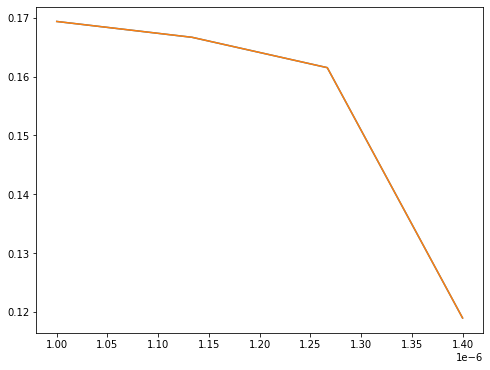

In [69]:

parDictName = 'new_parameter' # Reference parameter dictionary key

x = mmi.getsweepresult('SweepTest','new_result')
print(x.keys())
y = x['user s matrix']
# print(np.shape(y))
# print(y[:,:,0])

S = np.zeros((np.size(x[parDictName]), 2))
for i in range(np.size(x[parDictName])):
    S[i,:] = abs(y[1:,0,i])**2

X = list(x[parDictName])

print(np.transpose(abs(S[:,0])**2))
print(np.transpose(abs(S[:,1])**2))

plt.plot(X[0], np.transpose(abs(S[:,0])**2),'-')
plt.plot(X[0], np.transpose(abs(S[:,1])**2),'-')

## Script Sweeps

Using python to execute sweeps in lumerical, excrating its results right after

### Tapper length sweep

Tapper width sweep in progress...
Number of output ports found: 2
Progress: 1/32
Progress: 2/32
Progress: 3/32
Progress: 4/32
Progress: 5/32
Progress: 6/32
Progress: 7/32
Progress: 8/32
Progress: 9/32
Progress: 10/32
Progress: 11/32
Progress: 12/32
Progress: 13/32
Progress: 14/32
Progress: 15/32
Progress: 16/32
Progress: 17/32
Progress: 18/32
Progress: 19/32
Progress: 20/32
Progress: 21/32
Progress: 22/32
Progress: 23/32
Progress: 24/32
Progress: 25/32
Progress: 26/32
Progress: 27/32
Progress: 28/32
Progress: 29/32
Progress: 30/32
Progress: 31/32
Progress: 32/32


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

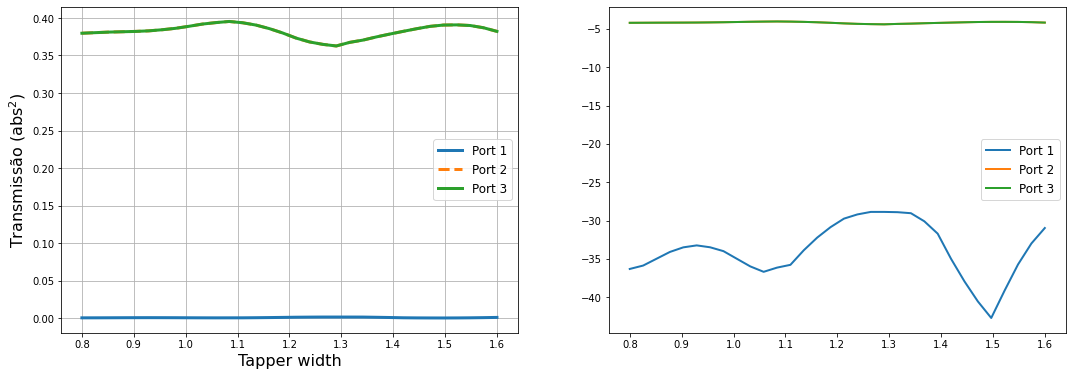

In [114]:
pMatrix = np.zeros((TSPoints,SParSz))
kMatrix = np.zeros((TSPoints,SParSz))
TRangeMatrix = np.linspace(TSRange[0],TSRange[1],TSPoints)

mmi.selectpartial("Output Taper")
OutP = int(mmi.getnumber())
print("Tapper width sweep in progress...")
print("Number of output ports found: " + str(OutP))

for i in range(TSPoints):
    text = "Progress: " + str(i+1) + "/" + str(TSPoints)
    print(text)   
        
    mmi.switchtolayout()
    for j in range(OutP):
        mmi.setnamed("Output Taper " +str(j+1),
        "width_l",TRangeMatrix[i])
        
    mmi.run()
    mmi.emepropagate()
        
    A = mmi.getresult("EME","user s matrix")
    for j in range(SParSz):
        pMatrix[i,j] = abs(A[SPar[j]-1,0])**2
        kMatrix[i,j] = 20*np.log10(abs(A[SPar[j]-1,0]))

    pointResults = [pMatrix[i][:],kMatrix[i][:]]

    completeName = os.path.join('../SavedData/TapperWidth','Data'+str(i+1))
    MSOutfile = open(completeName,'wb')
    plk.dump(pointResults,MSOutfile)
    MSOutfile.close()

figure1, swp = plt.subplots(1, 2, figsize=(18,6))

for i in range(SParSz):
    if(i%2==0):
        swp[0].plot(1e6*TRangeMatrix,np.transpose(pMatrix[:,i]), '--', label='Port '+str(i+1), linewidth=3)
        swp[1].plot(1e6*TRangeMatrix,np.transpose(kMatrix[:,i]), '-', label='Port '+str(i+1), linewidth=2)
    else:
        swp[0].plot(1e6*TRangeMatrix,np.transpose(pMatrix[:,i]), '--',label='Port '+str(i+1), linewidth=3)
        swp[1].plot(1e6*TRangeMatrix,np.transpose(kMatrix[:,i]), '-', label='Port '+str(i+1), linewidth=2)

swp[0].legend(fontsize=12)
swp[0].set_xlabel('Tapper width (um)',fontsize=16)
swp[0].set_ylabel(r'Transmissão (abs$^{2}$)',fontsize=16)
swp[0].grid(True)

swp[1].legend(fontsize=12)
swp[1].set_xlabel('Tapper width (um)',fontsize=16)
swp[1].set_ylabel('Transmissão (dB)',fontsize=16)
swp[1].grid(True)

### Mesh sweep

Mesh sweep in progress...
Mesh sweep type set to multiplier
Progress: 1/15
Progress: 2/15
Progress: 3/15
Progress: 4/15
Progress: 5/15
Progress: 6/15
Progress: 7/15
Progress: 8/15
Progress: 9/15
Progress: 10/15
Progress: 11/15
Progress: 12/15
Progress: 13/15
Progress: 14/15
Progress: 15/15


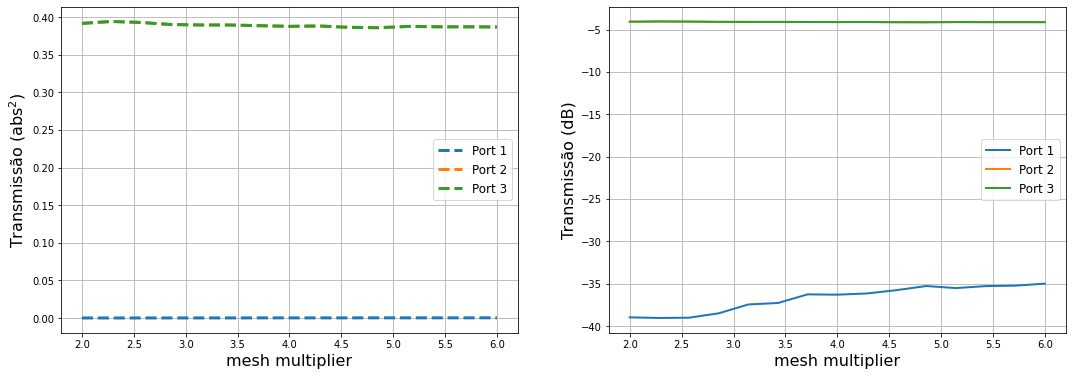

In [104]:
pMatrix = np.zeros((SMPoints,SParSz))
kMatrix = np.zeros((SMPoints,SParSz))
SMRMatrix = np.linspace((SMRange[0][0], SMRange[1][0]),(SMRange[0][1], SMRange[1][1]), SMPoints)
labelstr = ['0','0','0','0']

print("Mesh sweep in progress...")

if(SMType==0):
    meshType = 'set maximum mesh step'
    labelstr[0] = 'maximum mesh step (um)'
    labelstr[1:3] = ['dx','dy','dz']
    yscale = 1e6
    print("Mesh sweep type set to maximum step")
else:
    meshType = 'set mesh multiplier'
    labelstr[0] = 'mesh multiplier'
    labelstr[1:3] = ['x mesh multiplier','y mesh multiplier','z mesh multiplier']
    yscale = 1e0
    print("Mesh sweep type set to multiplier")

for i in range(SMPoints):
    text = "Progress: " + str(i+1) + "/" + str(SMPoints)
    print(text)

    mmi.switchtolayout()

    mmi.selectpartial("_mesh")
    mmi.set(meshType,1)
    mmi.set(labelstr[1],SMRMatrix[i][SMType])
    mmi.set(labelstr[2],SMRMatrix[i][SMType])
    mmi.set(labelstr[3],SMRMatrix[i][SMType])

    mmi.run()
    mmi.emepropagate()
    
    A = mmi.getresult("EME","user s matrix")
    for j in range(SParSz):
        pMatrix[i,j] = abs(A[SPar[j]-1,0])**2
        kMatrix[i,j] = 20*np.log10(abs(A[SPar[j]-1,0]))

    pointResults = [pMatrix[i][:],kMatrix[i][:]]

    completeName = os.path.join('../SavedData/MeshSweep','Data'+str(i+1))
    MSOutfile = open(completeName,'wb')
    plk.dump(pointResults,MSOutfile)
    MSOutfile.close()

figure1, swp = plt.subplots(1, 2, figsize=(18,6))

for i in range(SParSz):
    labelstr2 = 'Port '+str(i+1)
    if(i%2==0):
        swp[0].plot(yscale*SMRMatrix[:,SMType],np.transpose(pMatrix[:,i]), '--', label=labelstr2, linewidth=3)
        swp[1].plot(yscale*SMRMatrix[:,SMType],np.transpose(kMatrix[:,i]), '-', label=labelstr2, linewidth=2)
    else:
        swp[0].plot(yscale*SMRMatrix[:,SMType],np.transpose(pMatrix[:,i]), '--',label=labelstr2, linewidth=3)
        swp[1].plot(yscale*SMRMatrix[:,SMType],np.transpose(kMatrix[:,i]), '-', label=labelstr2, linewidth=2)

swp[0].legend(fontsize=12)
swp[0].set_xlabel(labelstr[0],fontsize=16)
swp[0].set_ylabel(r'Transmissão (abs$^{2}$)',fontsize=16)
swp[0].grid(True)

swp[1].legend(fontsize=12)
swp[1].set_xlabel(labelstr[0],fontsize=16)
swp[1].set_ylabel('Transmissão (dB)',fontsize=16)
swp[1].grid(True)

## Load Data
Load saved data from sweeps

In [113]:
loadFolder = 'TapperWidth' # Folder to load

loadPath = '../SavedData/'+str(loadFolder)
file_count = sum(len(files) for _, _, files in os.walk(loadPath))
data = {}

for i in range(file_count):
    infile = open(os.path.join(loadPath, 'Data'+str(i+1)) , 'rb')
    data['Load'+str(i+1)] = plk.load(infile)
    infile.close()
    
print(data)
dataFrame = pd.DataFrame(data)
dataFrame

{'Load1': [array([2.33779405e-04, 3.79685266e-01, 3.79685265e-01]), array([-36.3119375 ,  -4.20576256,  -4.20576256])]}


,Load1
0,"[0.00023377940532624423, 0.3796852655784191, 0..."
1,"[-36.31193750433042, -4.205762561711044, -4.20..."


[2.         2.28571429 2.57142857 2.85714286 3.14285714 3.42857143
 3.71428571 4.         4.28571429 4.57142857 4.85714286 5.14285714
 5.42857143 5.71428571 6.        ]


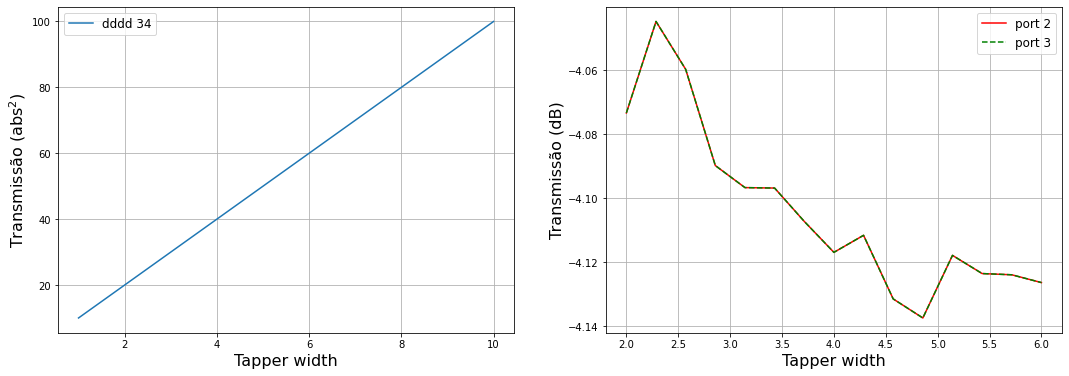

In [105]:
A = np.array([1,2,3,4,5,6,7,8,9,10])
B = [2,3,4,9,11,8,7,5,12,2]
C = [4,8,19,14,17,11,10,8,3,9]
afs = 'dddd '+str(34)

print(SMRMatrix[:,1])
A1 = SMRMatrix[:,1]

figure1, aps = plt.subplots(1, 2, figsize=(18,6))

aps[0].set_ylabel(r'Transmissão (abs$^{2}$)', fontsize=16)
aps[0].set_xlabel('Tapper width',fontsize=16)
aps[0].plot(A,10*A,label=afs)
aps[0].legend(fontsize=12)
aps[0].grid()

aps[1].set_ylabel('Transmissão (dB)', fontsize=16)
aps[1].set_xlabel('Tapper width',fontsize=16)
aps[1].plot(A1,kMatrix[:,1],'-',label='port 2',color='r')
aps[1].plot(A1,kMatrix[:,2],'--',label='port 3',color='g')
aps[1].legend(fontsize=12)
aps[1].grid()